In [1]:
# Import relevant libraries for the project
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
plt.style.use('dark_background')

In [3]:
# Specify directory of train data
dir_train = 'E:/Github_Repos/Defect-Detection-With-Robotic-Arm/roundCNN/dataset'
# dir_train_def = dir_train+'defect/'  # Class label: Defective
# dir_train_brok = dir_train+'broken/'  # Class label: Defective
# dir_train_good = dir_train+'good/'    # Class label: OK

In [4]:
# Define instances of ImageDataGenerator
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Specify parameters/arguments for data generation
img_size, batch_size, rand_seed = (500, 500), 64, 0
arg_train = {'target_size': img_size,
             'color_mode': 'grayscale',
             'classes': {'defect': 0,
                         'good': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}


# Generate data by iterating through directories
train_set = train_gen.flow_from_directory(
    directory=dir_train, subset='training', **arg_train)
valid_set = train_gen.flow_from_directory(
    directory=dir_train, subset='validation', **arg_train)


Found 864 images belonging to 2 classes.


Found 216 images belonging to 2 classes.


In [5]:
# Define CNN model architecture
cnn_model = Sequential([ 
    # First block
    Conv2D(32, 3, activation='relu', padding='same', strides=2,input_shape=img_size+(1,)),
    MaxPooling2D(pool_size=2, strides=2),
    # Second block
    Conv2D(64, 3, activation='relu', padding='same', strides=2),
    MaxPooling2D(pool_size=2, strides=2),
    # Flatenning
    Flatten(),
    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')        # Only 1 output
])

# Compile model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Default lr
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Display summary of model architecture
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dense (Dense)               (None, 128)               7

In [6]:
%%time

# Fit model using train set and validation set
n_epochs = 15
cnn_model.fit(
    train_set,
    validation_data=valid_set,
    epochs=n_epochs,
    verbose=1)

Epoch 1/15
14/14 [==============================] - 32s 2s/step - loss: 1.1033 - accuracy: 0.5266 - val_loss: 0.7033 - val_accuracy: 0.5185
Epoch 2/15
14/14 [==============================] - 19s 1s/step - loss: 0.6900 - accuracy: 0.5185 - val_loss: 0.6715 - val_accuracy: 0.5185
Epoch 3/15
14/14 [==============================] - 20s 1s/step - loss: 0.6353 - accuracy: 0.6863 - val_loss: 0.5473 - val_accuracy: 0.7731
Epoch 4/15
14/14 [==============================] - 20s 1s/step - loss: 0.5558 - accuracy: 0.7535 - val_loss: 0.5178 - val_accuracy: 0.7407
Epoch 5/15
14/14 [==============================] - 19s 1s/step - loss: 0.5094 - accuracy: 0.7662 - val_loss: 0.5143 - val_accuracy: 0.7917
Epoch 6/15
14/14 [==============================] - 14s 994ms/step - loss: 0.4906 - accuracy: 0.7801 - val_loss: 0.5286 - val_accuracy: 0.7361
Epoch 7/15
14/14 [==============================] - 14s 977ms/step - loss: 0.5081 - accuracy: 0.7419 - val_loss: 0.5723 - val_accuracy: 0.6898
Epoch 8/15
14/

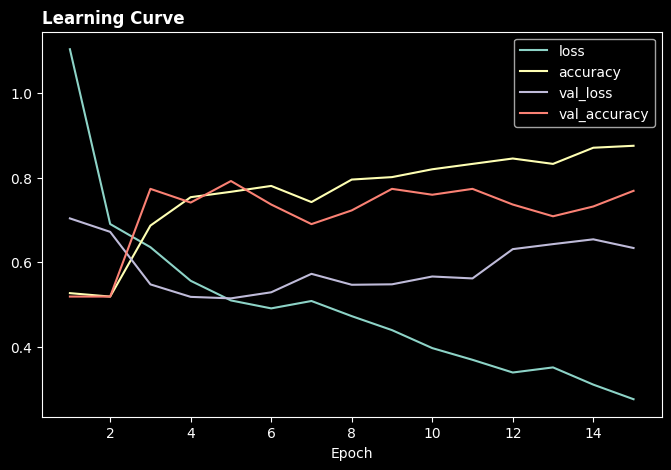

In [7]:
# Plot learning curve from model history
histo_dict = cnn_model.history.history
histo_df = pd.DataFrame(histo_dict, index=range(1,n_epochs+1))
fig, ax = plt.subplots(figsize=(8,5))
for m in histo_df.columns:
    ax.plot(histo_df.index, m, data=histo_df)
ax.set_xlabel('Epoch')
ax.set_title('Learning Curve', loc='left', weight='bold')
ax.legend()
plt.show()

In [9]:
cnn_model.predict("E:/Github_Repos/Defect-Detection-With-Robotic-Arm/roundCNN/dataset/good/img5009.jpg", verbose=1)


IndexError: tuple index out of range

In [27]:
# Make predictions on images in the test set
best_model = cnn_model
y_pred_prob = best_model.predict("E:/Github_Repos/Defect-Detection-With-Robotic-Arm/roundCNN/dataset/good/img5009.jpg", verbose=1)
y_pred = (y_pred_prob >= 0.5).reshape(-1,)
y_true = test_set.classes[test_set.index_array]

12/12 [==============================] - 2s 121ms/step


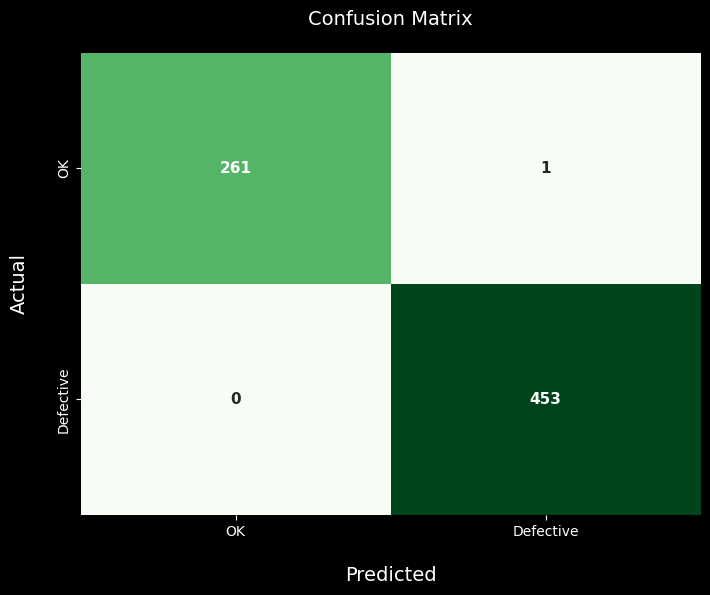

In [28]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,
                 annot_kws={'size':11, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Greens')
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')

ax.set_title("Confusion Matrix", fontsize=14, pad=20)
plt.show()

In [29]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9962    0.9981       262
           1     0.9978    1.0000    0.9989       453

    accuracy                         0.9986       715
   macro avg     0.9989    0.9981    0.9985       715
weighted avg     0.9986    0.9986    0.9986       715



In [8]:
cnn_model.save('modelRing.h5')

In [36]:

# importing numpy
import numpy as np
 
array = np.random.rand(2, 2, 2, 2)
print(array, end="\n\n\n")
print(array[..., 0])


[[[7.86127449e-01 7.46417959e-01]
  [4.70596630e-04 9.90032754e-01]]

 [[3.60707347e-01 4.66426176e-01]
  [7.18675887e-01 9.48224530e-01]]]
